In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from pprint import pprint

from warnings import filterwarnings
filterwarnings('ignore')

#### Helper Functions

In [2]:
def model_and_evaluate(mode, plot=False):
    
    # Names of models
    model_labels = [
#         'LinearRegression',
          'Lasso',
          'Ridge',
          'DecisionTreeRegressor',
          'KNeighborsRegressor',
          'MLPRegressor',
          'RandomForestRegressor',
          'XGBRegressor',
          'XGBRFRegressor', 
          'SVR', 
          'AdaBoostRegressor'            
         ]

    # Regression Models with default hyper-parameters
    models = [
#         LinearRegression(normalize=True),
          Lasso(alpha=0.001),
          Ridge(),
          DecisionTreeRegressor(),
          KNeighborsRegressor(weights='distance'),
          MLPRegressor(random_state=42, max_iter=2000),
          RandomForestRegressor(),
          XGBRegressor(objective='reg:squarederror'),
          XGBRFRegressor(objective='reg:squarederror', learning_rate=1), 
          SVR(C=500000), 
          AdaBoostRegressor()
    ]

    r2_scores = []
    mse_scores = []
    mae_scores = []

    for i, (model, name) in enumerate(zip(models, model_labels)):

        model.fit(X_train, y_train)
        
        if mode == 'train':
            y_pred = model.predict(X_train)
            evaluation = y_train
#             print("On Training Data")
        elif mode == 'test':
            y_pred = model.predict(X_test)
            evaluation = y_test
#             print("On Testing Data")


        r2_scores.append(round(metrics.r2_score(evaluation, y_pred), 4))
        mse_scores.append(metrics.mean_squared_error(evaluation, y_pred))
        mae_scores.append(metrics.mean_absolute_error(evaluation, y_pred))  
        
        if plot:
            plt.scatter(evaluation, y_pred)
            plt.xlabel("True Labels")
            plt.ylabel("Predictions")
            plt.title(name)
            plt.show()
        
    evaluation_df = pd.DataFrame({"model" : model_labels,
                                  "R-squared": r2_scores, 
                                  "MSE" : mse_scores, 
                                  "MAE" : mae_scores}).sort_values(by=['R-squared'], ascending=False)
    
    
    
    return evaluation_df.reset_index(drop=True).set_index('model')

In [3]:
# Read dataset
data = pd.read_csv("../../Copper Dataset (version 2.0).csv")

# Split into features and target variables
X = data.iloc[:, :-2]
y = data['tensile_strength']

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=327)  # (1029 in train/ 258 in test)

In [4]:
# # Model using multiple techniques

# # Evaluate on training data
# train_eval = model_and_evaluate('train')
# print(train_eval)

# # Evaluate on testing data
# test_eval = model_and_evaluate('test')
# print(test_eval)

# Best Models

In [5]:
# # Mask for models with R-squared score > 0.8
# mask = test_eval['R-squared'] > 0.8
# best_models = test_eval[mask].index.values

# # Display names of the best performing models
# print("Models with r-squared > 0.80 are :-\n")

# for i, model_name in enumerate(best_models):
#     print("{}. {}".format(i+1, model_name))

# Hyperparameter Tuning for each model

**1. XGBR Regressor** 

a. Hyperparamter tuning with **RandomizedSearchCV**\
b. Hyperparamter tuning with **GridSearchCV**

#### Random Search Cross Validation

In [6]:
# Create grid for RandomizedSearchCV

# Create the random grid
random_grid = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
               "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
               "min_child_weight" : [ 1, 3, 5, 7 ],
               "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
               "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
              }

pprint(random_grid)

{'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
 'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight': [1, 3, 5, 7]}


In [7]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = XGBRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3,   # 3 folds
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)
# Fit the random search model
_ = rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   27.2s finished


[17:12:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


We can view the **best parameters** from fitting the random search:

In [8]:
rf_random.best_params_

{'min_child_weight': 1,
 'max_depth': 12,
 'learning_rate': 0.1,
 'gamma': 0.3,
 'colsample_bytree': 0.5}

### Evaluate Random Search

To determine if random search yielded a better model, we **compare the base model** with the **best random search model**.

In [9]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print()
    return accuracy


base_model = XGBRegressor(objective='reg:squarederror')
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 7.7810 degrees.
Accuracy = 88.09%.

Model Performance
Average Error: 4.4894 degrees.
Accuracy = 93.14%.

Improvement of 5.73%.


In [10]:
model_name = "XGBoost Regressor"
y_pred = best_random.predict(X_test)

r2_scores = round(metrics.r2_score(y_test, y_pred), 4)
mse_scores = metrics.mean_squared_error(y_test, y_pred)
mae_scores = metrics.mean_absolute_error(y_test, y_pred)
        
evaluation_df = pd.DataFrame({"R-squared": r2_scores, 
                              "MSE" : mse_scores, 
                              "MAE" : mae_scores}, index=[model_name])

evaluation_df

,R-squared,MSE,MAE
XGBoost Regressor,0.961,51.617039,4.489351


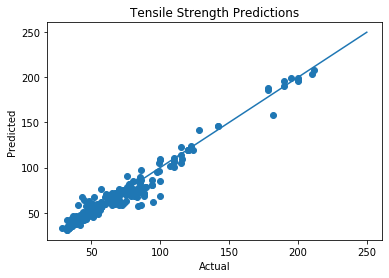

In [11]:
plt.scatter(y_test, y_pred)
plt.plot([50, 250], [50,250])
plt.title("Tensile Strength Predictions")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

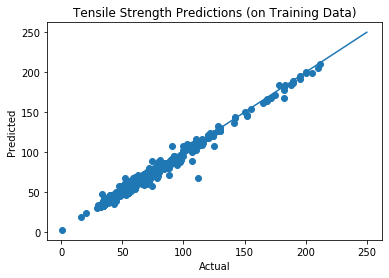

In [13]:
plt.scatter(y_train, best_random.predict(X_train))
plt.plot([50, 250], [50,250])
plt.title("Tensile Strength Predictions (on Training Data)")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()